In [1]:
import agama, numpy as np, scipy.integrate, scipy.special
import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi
import gala.units as gu
import matplotlib, matplotlib.pyplot as plt
import astropy.units as u
import os
%matplotlib inline
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

Setting agama and gala units to be consistent with Tango for three simulations of MW--LMC

In [2]:
mass_unit =232500
agama.setUnits(length=1, velocity=1, mass=mass_unit)
timeUnitGyr = agama.getUnits()['time'] / 1e3
agama.getUnits()

{'length': <Quantity 1. kpc>,
 'velocity': <Quantity 1. km / s>,
 'time': <Quantity 977.79222168 Myr>,
 'mass': <Quantity 232500. solMass>}

In [3]:
usys = gu.UnitSystem(u.kpc, 977.79222168*u.Myr, mass_unit*u.Msun, u.radian, u.km/u.s)
usys

<UnitSystem (kpc, 977.79222168 Myr, 232500.0 solMass, rad)>

Taking the potential for the MW-LMC system from Eugene's Tango for three paper

In [4]:
## initialize the potential of the Milky Way + LMC in two variants
## parameters of the Milky Way + LMC potential for the case of moving LMC but non-evolving potentials.
## Units: length=1 kpc, velocity=1 km/s, mass=232500 Msun, G=1

pot_frozen   = agama.Potential('potentials_triax/potential_frozen.ini')   # fixed analytic potentials
pot_evolving = agama.Potential('potentials_triax/potential_evolving.ini') # time-dependent multipole potentials

Eugene's particle spray method to generate a stream in agama

In [5]:
def createICforParticleSpray(pot_host, orb_sat, mass_sat, gala_modified=True):
    """
    Create initial conditions for particles escaping through Largange points,
    using the method of Fardal+2015
    Arguments:
        pot_host:  an instance of agama.Potential.
        orb_sat:   the orbit of the satellite, an array of shape (N, 6).
        mass_sat:  the satellite mass (a single number or an array of length N).
        gala_modified:  if True, use modified parameters as in Gala, otherwise the ones from the original paper.
    Return:
        initial conditions for stream particles, an array of shape (2*N, 6) - 
        two points for each point on the original satellite trajectory.
    """
    N = len(orb_sat)
    x, y, z, vx, vy, vz = orb_sat.T
    Lx = y * vz - z * vy
    Ly = z * vx - x * vz
    Lz = x * vy - y * vx
    r = (x*x + y*y + z*z)**0.5
    L = (Lx*Lx + Ly*Ly + Lz*Lz)**0.5
    # rotation matrices transforming from the host to the satellite frame for each point on the trajectory
    R = np.zeros((N, 3, 3))
    R[:,0,0] = x/r
    R[:,0,1] = y/r
    R[:,0,2] = z/r
    R[:,2,0] = Lx/L
    R[:,2,1] = Ly/L
    R[:,2,2] = Lz/L
    R[:,1,0] = R[:,0,2] * R[:,2,1] - R[:,0,1] * R[:,2,2]
    R[:,1,1] = R[:,0,0] * R[:,2,2] - R[:,0,2] * R[:,2,0]
    R[:,1,2] = R[:,0,1] * R[:,2,0] - R[:,0,0] * R[:,2,1]
    # compute  the second derivative of potential by spherical radius
    der = pot_host.forceDeriv(orb_sat[:,0:3])[1]
    d2Phi_dr2 = -(x**2  * der[:,0] + y**2  * der[:,1] + z**2  * der[:,2] +
                  2*x*y * der[:,3] + 2*y*z * der[:,4] + 2*z*x * der[:,5]) / r**2
    # compute the Jacobi radius and the relative velocity at this radius for each point on the trajectory
    Omega = L / r**2
    rj = (agama.G * mass_sat / (Omega**2 - d2Phi_dr2))**(1./3)
    vj = Omega * rj
    # assign positions and velocities (in the satellite reference frame) of particles
    # leaving the satellite at both lagrange points.
    rj = np.repeat(rj, 2) * np.tile([1, -1], N)
    vj = np.repeat(vj, 2) * np.tile([1, -1], N)
    mean_x  = 2.0
    disp_x  = 0.5 if gala_modified else 0.4
    disp_z  = 0.5
    mean_vy = 0.3
    disp_vy = 0.5 if gala_modified else 0.4
    disp_vz = 0.5
    rx  = np.random.normal(size=2*N) * disp_x + mean_x
    rz  = np.random.normal(size=2*N) * disp_z * rj
    rvy =(np.random.normal(size=2*N) * disp_vy + mean_vy) * vj * (rx if gala_modified else 1)
    rvz = np.random.normal(size=2*N) * disp_vz * vj
    rx *= rj
    ic_stream = np.tile(orb_sat, 2).reshape(2*N, 6)
    ic_stream[:,0:3] += np.einsum('ni,nij->nj',
        np.column_stack([rx,  rx*0, rz ]), np.repeat(R, 2, axis=0))
    ic_stream[:,3:6] += np.einsum('ni,nij->nj',
        np.column_stack([rx*0, rvy, rvz]), np.repeat(R, 2, axis=0))
    return ic_stream

In [6]:
def createStreamParticleSpray(time_total, num_particles, pot_host, posvel_sat, mass_sat, gala_modified=True):
    
    # integrate the orbit of the progenitor from its present-day posvel (at time t=0)
    # back in time for an interval time_total, storing the trajectory at num_steps points
    print(posvel_sat.shape)
    time_sat, orbit_sat = agama.orbit(potential=pot_host, ic=posvel_sat,
        time=time_total, trajsize=num_particles//2)
    # reverse the arrays to make them increasing in time
    time_sat  = time_sat [::-1]
    orbit_sat = orbit_sat[::-1]

    # at each point on the trajectory, create a pair of seed initial conditions
    # for particles released at Lagrange points
    ic_stream = createICforParticleSpray(pot_host, orbit_sat, mass_sat, gala_modified=gala_modified)
    time_seed = np.repeat(time_sat, 2)
    xv_stream = np.vstack(agama.orbit(potential=pot_host,
        ic=ic_stream, time=-time_seed, timestart=time_seed, trajsize=1)[:,1])
    return time_sat, orbit_sat, xv_stream, ic_stream

Generating an example OC stream from initial conditions of the progenitor today

In [7]:
# rotation matrix converting from the ICRS to Orphan-Chenab stream coordinates (appendix B of Koposov+2019)
fromICRStoOS = agama.makeCelestialRotationMatrix(191.10487 * np.pi/180, -62.86084 * np.pi/180, 2.129813)
print('Rotation matrix for conversion from ICRS to the OC stream coordinate system:\n%s' % fromICRStoOS)

# coordinates of the fiducial progenitor of the Orphan-Chenab stream (appendix A of Erkal+2019)
ra, dec = agama.transformCelestialCoords(fromICRStoOS.T, 6.34 * np.pi/180, 0)
ra = ra * 180/np.pi + 360
dec = dec * 180/np.pi
dist, pmra, pmdec, vlos = 18.76, -3.68, 2.88, 107.6
l, b, pml, pmb = agama.transformCelestialCoords(agama.fromICRStoGalactic,
    ra * np.pi/180, dec * np.pi/180, pmra, pmdec)
posvelProgenitor = agama.getGalactocentricFromGalactic(l, b, dist, pml*4.74, pmb*4.74, vlos)

Rotation matrix for conversion from ICRS to the OC stream coordinate system:
[[-0.44761236 -0.08785756 -0.88990125]
 [-0.84246077  0.37511386  0.38671624]
 [ 0.29983835  0.92280585 -0.24192215]]


In [34]:
def readparams(paramfile):
    """
    Read in the stream model parameters
    """
    
    print("Opening parameter yaml file...")
    with open(paramfile) as f:
        d = yaml.safe_load(f)

    inpath = d["inpath"]
    snapname = d["snapname"]
    outpath = d["outpath"]
    outname = d["outname"]
    prog_ics = np.array(d["prog_ics"])
    prog_mass = d["prog_mass"]
    prog_scale = d["prog_scale"] # kpc
    pericenter = d["pericenter"]
    apocenter = d["apocenter"]
    Tbegin = d["Tbegin"]
    Tfinal =  d["Tfinal"]
    num_particles = d["num_particles"]
    
    print("Read yaml contents and returning function...")

    return [inpath, snapname, outpath, outname, prog_ics ,prog_mass, prog_scale, pericenter, apocenter, Tbegin, Tfinal, num_particles]

In [35]:
import yaml
params = readparams('../ics/high-vel-dis/agama-mw/param_0.yaml')  

Opening parameter yaml file...
Read yaml contents and returning function...


In [36]:
inpath, snapname, outpath, filename, \
    fc, Mprog, a_s, pericenter, apocenter, Tbegin, Tfinal, num_particles = params

In [38]:
mass_sat   = 1e7/mass_unit  # in Msun
radius_sat = 1  # in kpc; not used in the particle-spray method, but will be used later
time_total = -5.0/timeUnitGyr.value  # in time units (0.978 Gyr)
num_particles = int(2e4)  # number of particles in the stream


time_sat, orbit_sat, xv_stream, ic_stream = createStreamParticleSpray(time_total, 
                                                                      num_particles,
                                                                      pot_frozen,
                                                                      np.array(fc), 
                                                                      mass_sat)

(6,)


/tmp/ipykernel_55253/2497709856.py:38: RuntimeWarning: invalid value encountered in power
  rj = (agama.G * mass_sat / (Omega**2 - d2Phi_dr2))**(1./3)


In [43]:
type(xv_stream[:,:3].)

type(time_sat)

numpy.ndarray

In [57]:
orbit_sat.shape

(10000, 6)

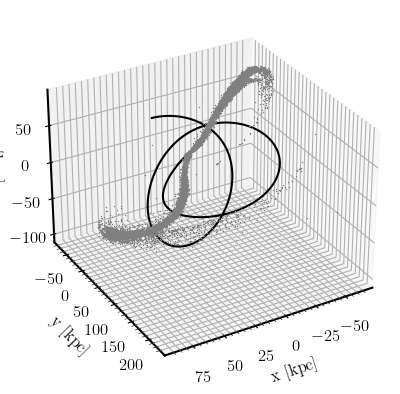

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.plot(orbit_sat[:,0], orbit_sat[:,1], orbit_sat[:,2], c='k')
plt.plot(xv_stream[:,0], xv_stream[:,1], xv_stream[:,2], 'o', ms=1, mew=0, c='grey')

ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_zlabel('z [kpc]')

ax.view_init(azim = 60, elev =30) #azim,: -60, 60


Sampling from agama/gala to get initial conditons for many streams

In [7]:
pothalo = agama.Potential(type = 'Spheroid', mass = 6.5e11/mass_unit, scaleRadius  = 14,
                          outerCutoffRadius = 300,cutoffStrength = 4,gamma = 1,beta = 3)

potbulge = agama.Potential(type='Spheroid', mass=51600, scaleRadius=0.2, outerCutoffRadius = 1.8,
                          gamma=0.0, beta=1.8, axisRatioZ=1.0)

potdisc = agama.Potential(type='Disk', SurfaceDensity=3803.5, ScaleRadius=3.0,ScaleHeight= -0.4)

totpot = agama.Potential(pothalo, potdisc, potbulge)

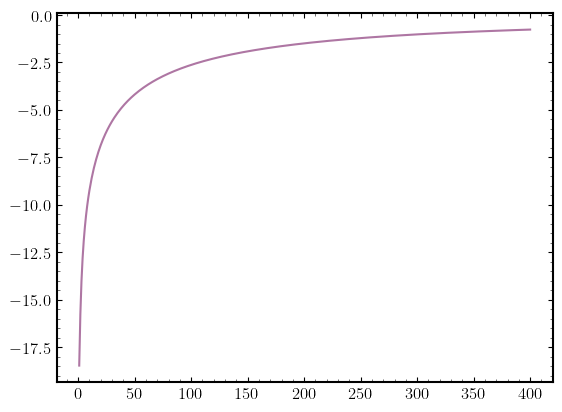

In [8]:
rs = np.linspace(1,400,400)

xyz = np.zeros(shape=(400,3))

xyz[:,2] = rs

pot = totpot.potential(xyz)
plt.plot(rs,pot/1e4)

In [9]:
dens = agama.Density(type="Dehnen", scaleRadius=15)
df = agama.DistributionFunction(type="QuasiSpherical", potential=totpot, density=dens)
gm = agama.GalaxyModel(totpot, df)

In [10]:
xv = gm.sample(128)[0]

In [11]:
def F_rigid(t, w):

    pothalo = agama.Potential(type = 'Spheroid', mass = 6.5e11/mass_unit, scaleRadius  = 14,
                          outerCutoffRadius = 300,cutoffStrength = 4,gamma = 1,beta = 3)
    potbulge = agama.Potential(type='Spheroid', mass=51600, scaleRadius=0.2, outerCutoffRadius = 1.8,
                              gamma=0.0, beta=1.8, axisRatioZ=1.0)
    
    potdisc = agama.Potential(type='Disk', SurfaceDensity=3803.5, ScaleRadius=3.0,ScaleHeight= -0.4)
    
    totpot = agama.Potential(pothalo, potdisc, potbulge)
    
    wdot = np.zeros_like(w)
    wdot[3:] = totpot.force(w[:3].T).T
    wdot[:3] = w[3:]
    return wdot

In [27]:
w0 = gd.PhaseSpacePosition.from_w(xv.T, units=usys)

In [28]:
Integrators = {'Leapfrog': gi.LeapfrogIntegrator, 
                        'RK4': gi.Ruth4Integrator, 
                        'RK5': gi.RK5Integrator,
                        'DOPRI853': gi.DOPRI853Integrator}


integrator=Integrators['Leapfrog'](F_rigid, func_units=usys, progress=False)
wf = integrator.run(w0,  dt= 1 * u.Myr, t1=0* u.Gyr, t2= 5 * u.Gyr)

In [29]:
pericenters = wf.pericenter()
apocenters = wf.apocenter()

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [30]:
peri_mask = (pericenters > 5*u.kpc) & (pericenters < 25*u.kpc)
apo_mask = (apocenters < 50*u.kpc)

cut_xv = xv[peri_mask & apo_mask]
print("The number of streams passing critera: {}".format(len(cut_xv)))

The number of streams passing critera: 32


In [35]:
%pip list -l --format=freeze > agama-analysis-venv-requirements.txt


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
